This is the notebook I created for data analysis, charts, and processing to model building, training, and accuracy testing.

In [ ]:
%tensorflow_version 2.x

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns
print("Imported All Libraries")

Imported All Libraries


In [ ]:
dataframe = pd.read_csv("https://drive.google.com/uc?export=download&id=1Z6VGqFerTHreeIRW6e01vd3hkA76U3xf")
dataframe.sample(frac=1)
print("Read Heart Failure CSV")

Read Heart Failure CSV


In [ ]:
# show first 5 records
dataframe.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [ ]:
# view column info
# our data is all numeric (int, float)
# we have 11 potential features
# DEATH_EVENT serves as the label for each record
# no null values present in whole dataset
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [ ]:
# overview of column stats
dataframe.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


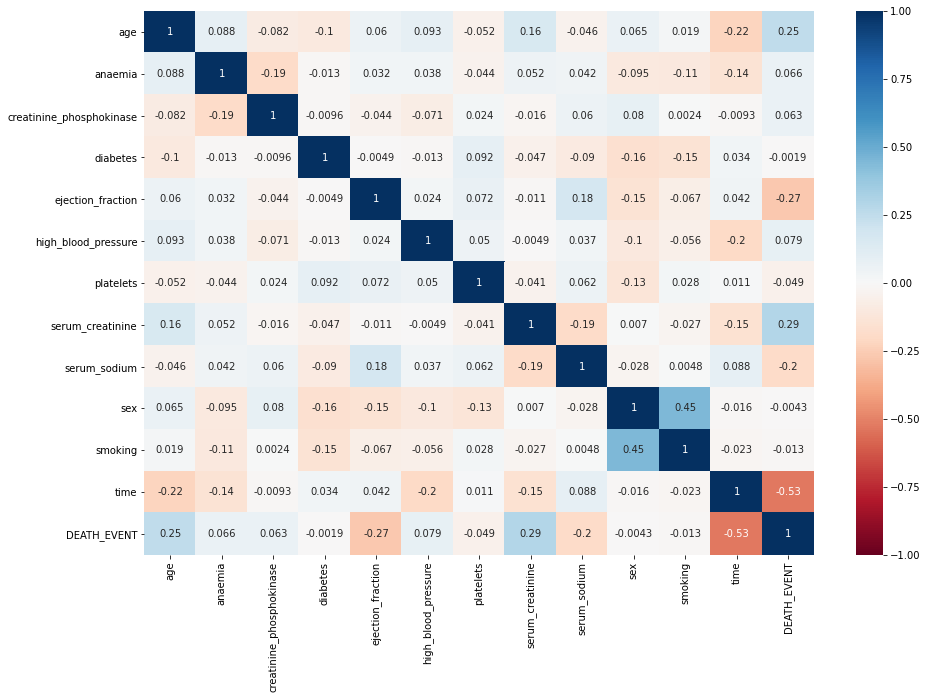

In [ ]:
# view a heat map of the correlations of all the data
# this will show any correlations between each column 
# we can use this to see how the 11 potential features correlate to the label
# we can use the rightmost column of correlations to determine features to use
correlations = dataframe.corr()
plt.figure(figsize=[15, 10])
sns.heatmap(correlations, vmin=-1, annot=True, cmap='RdBu')

In [ ]:
# the following columns seem to correlate the most to death event
# time, serum_creatinine, ejection_fraction, age, serum_sodium
death_event_corr = abs(correlations["DEATH_EVENT"])
sorted = death_event_corr.sort_values(ascending=False)
print(sorted)

DEATH_EVENT                 1.000000
time                        0.526964
serum_creatinine            0.294278
ejection_fraction           0.268603
age                         0.253729
serum_sodium                0.195204
high_blood_pressure         0.079351
anaemia                     0.066270
creatinine_phosphokinase    0.062728
platelets                   0.049139
smoking                     0.012623
sex                         0.004316
diabetes                    0.001943
Name: DEATH_EVENT, dtype: float64


In [ ]:
# we will use these rows as our features
# note that we are not considering the time column
# time represents the length of the follow-up period, which was shorter if a patient died (ending the follow-up period)
# our model predicts survivability as an early detection measure, so time shouldn't be considered
heart_data = dataframe.filter(['serum_creatinine', 'ejection_fraction', 'age', 'serum_sodium'], axis=1)
heart_data.head()

,serum_creatinine,ejection_fraction,age,serum_sodium
0,1.9,20,75.0,130
1,1.1,38,55.0,136
2,1.3,20,65.0,129
3,1.9,20,50.0,137
4,2.7,20,65.0,116


In [ ]:
# feature engineering: now we should normalize the features as z-scores so they are on the same scale
# without normalization, the model will not train properly
mean = heart_data.mean()
std_dev = heart_data.std()
normalized = (heart_data - mean) / std_dev
normalized["death_event"] = dataframe["DEATH_EVENT"]
normalized.head()

,serum_creatinine,ejection_fraction,age,serum_sodium,death_event
0,0.489237,-1.527998,1.190949,-1.501519,1
1,-0.284076,-0.007065,-0.490457,-0.141739,1
2,-0.090748,-1.527998,0.350246,-1.728149,1
3,0.489237,-1.527998,-0.910808,0.084892,1
4,1.262550,-1.527998,0.350246,-4.674340,1


In [ ]:
# split dataset into training and test
split = 250
training_data = normalized[:split]
test_data = normalized[split:]
print("Training data records: {}".format(len(training_data.index)))
print("Test data records: {}".format(len(test_data.index)))

Training data records: 250
Test data records: 49


In [ ]:
# represent features in feature columns
feature_columns = []

# time = tf.feature_column.numeric_column("time")
serum_creatinine = tf.feature_column.numeric_column("serum_creatinine")
ejection_fraction = tf.feature_column.numeric_column("ejection_fraction")
age = tf.feature_column.numeric_column("age")
serum_sodium = tf.feature_column.numeric_column("serum_sodium")
# feature_columns.append(time)
feature_columns.append(serum_creatinine)
feature_columns.append(ejection_fraction)
feature_columns.append(age)
feature_columns.append(serum_sodium)

# convert the features columns into a layer that will be fed into the model
feature_layer = layers.DenseFeatures(feature_columns)

# print layer output when applied to some training data
feature_layer(dict(training_data))

<tf.Tensor: shape=(250, 4), dtype=float32, numpy=
array([[ 1.19094872e+00, -1.52799797e+00,  4.89236802e-01,
        -1.50151885e+00],
       [-4.90457058e-01, -7.06490641e-03, -2.84076124e-01,
        -1.41738534e-01],
       [ 3.50245804e-01, -1.52799797e+00, -9.07478854e-02,
        -1.72814894e+00],
       [-9.10808504e-01, -1.52799797e+00,  4.89236802e-01,
         8.48915279e-02],
       [ 3.50245804e-01, -1.52799797e+00,  1.26254976e+00,
        -4.67433977e+00],
       [ 2.45200300e+00,  1.61927655e-01,  6.82565033e-01,
        -1.04825878e+00],
       [ 1.19094872e+00, -1.95047927e+00, -1.87411994e-01,
         8.48915279e-02],
       [-7.01056197e-02,  1.85185325e+00, -2.84076124e-01,
        -1.27488887e+00],
       [ 3.50245804e-01,  2.27433467e+00,  1.02580346e-01,
         3.11521590e-01],
       [ 1.61130011e+00, -2.60553747e-01,  7.73904562e+00,
        -8.21628690e-01],
       [ 1.19094872e+00, -7.06490641e-03,  2.51918316e+00,
        -1.27488887e+00],
       [ 9.8034

In [ ]:
# define a function to create the logistic regression classification model

def create_model(learning_rate, feature_layer, metrics):

  # model with sequential layers
  model = tf.keras.models.Sequential()

  # add the feature input layer
  model.add(feature_layer)

  # add the output layer with sigmoid activation
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,), activation=tf.sigmoid))

  # compile the model + layers into an exxecutable TensorFlow model
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate), 
                loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)

  return model

print("Defined create_model")

Defined create_model


In [ ]:
# define a function to train the logistic regression classification model

def train_model(model, dataset, num_epochs, label, batch_size):

  # convert feature data to name-values pairs
  features = {name: np.array(values) for name, values in dataset.items()}

  # get label data alone
  labels = np.array(features.pop(label))

  # fit the model and get results
  history = model.fit(x=features, y=labels, batch_size=batch_size, epochs=num_epochs, validation_split=0.2)

  # get the list of epochs and metric data
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist

print("Defined train_model")

Defined train_model


In [ ]:
# define a function to visualize training results

def plot_results(epochs, history, metrics):

  # plot the curves of the calssification metrics
  plt.figure(figsize=(15, 5))
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for metric in metrics:
    x = history[metric]
    plt.plot(epochs[1:], x[1:], label=metric)

  plt.legend()

print("Defined plot_results")

Defined plot_results


Epoch 1/20
Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


44/50 [=========================>....] - ETA: 0s - loss: 1.2457 - accuracy: 0.3295 - precision: 0.2278 - recall: 0.2400        WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'serum_creatinine': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float32>, 'ejection_fraction': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float32>, 'age': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float32>, 'serum_sodium': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float32>}
Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


50/50 [==============================] - 0s 8ms/step - loss: 1.2299 - accuracy: 0.3350 - precision: 0.2500 - recall: 0.2472 - val_loss: 1.0736 - val_accuracy: 0.4600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
50/50 [==============================] - 0s 2ms/step - loss: 1.1629 - accuracy: 0.3550 - precision: 0.2674 - recall: 0.2584 - val_loss: 1.0240 - val_accuracy: 0.4600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
50/50 [==============================] - 0s 2ms/step - loss: 1.1061 - accuracy: 0.3800 - precision: 0.2892 - recall: 0.2697 - val_loss: 0.9811 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
50/50 [==============================] - 0s 2ms/step - loss: 1.0504 - accuracy: 0.4050 - precision: 0.3125 - recall: 0.2809 - val_loss: 0.9374 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
50/50 [==============================] - 0s 2ms/step - loss: 0.9974 - accuracy: 

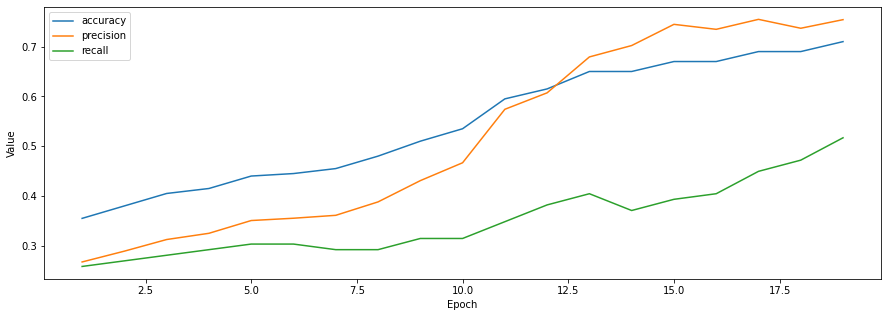

In [ ]:
# run the logistic regression binary classification process

# parameters
learning_rate = 0.002
epochs = 20
batch_size = 4
label_name = "death_event"
classification_threshold = 0.55

# provide the metrics to be used
metrics = [
  tf.keras.metrics.BinaryAccuracy(threshold=classification_threshold, name='accuracy'),
  tf.keras.metrics.Precision(thresholds=classification_threshold, name='precision'),
  tf.keras.metrics.Recall(thresholds=classification_threshold, name="recall"),
]

# create model
model = create_model(learning_rate, feature_layer, metrics)

# train model
epochs, history = train_model(model, training_data, epochs, label_name, batch_size)

# plot results
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall'] 
plot_results(epochs, history, list_of_metrics_to_plot)

In [ ]:
# determine accuracy on test set

features = {name: np.array(values) for name, values in test_data.items()}
labels = np.array(features.pop(label_name)).astype(np.float32)

# accuracy metrics
results = model.evaluate(x=features, y=labels)
print('\nAccuracy: {}'.format(results[1]*100))

Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


2/2 [==============================] - 0s 3ms/step - loss: 0.4933 - accuracy: 0.9184 - precision: 0.2500 - recall: 0.5000

Accuracy: 91.8367326259613


In [ ]:
# convert the model to TensorFlow Lite and get a .tflite file
# we can host the file-based tflite model and use it in a mobile app with Firebase
 
from google.colab import files
 
# convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
 
# save the model
open('model.tflite', 'wb').write(tflite_model)
files.download('model.tflite')

Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


INFO:tensorflow:Assets written to: /tmp/tmpmsxd2bln/assets


INFO:tensorflow:Assets written to: /tmp/tmpmsxd2bln/assets


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>